# Introduction: Finding Prevalence from Observations

In this notebook, we'll look at solving the following statistics problem in a Bayesian Framework. (Problem courtesy of Allen Downey on Twitter: [tweet link](https://twitter.com/AllenDowney/status/1063460263716892674))

> Today's Bayesian problem of the week: Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.
During the tour, we see 3 lions, 2 tigers, and 1 bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.
What is the probability that the next animal we see is a bear?

> Solution next week!

Our goal is to estimate the percentage of each species and determine the probability that the next animal is a bear. 

## Bayesian Approach

In a frequentist view, we would just use the observed animals to estimate the prevalence and let the data completely speak for itself. In contrast, in a Bayesian framework, we incorporate priors, which here are set to be equal for all species. In the case of infinite observations, the effect of the priors disappear and we only use the data. Due to the limited number of observations, the _priors_ will still have an large effect on the prevalence we obtain, and the _uncertainty_ will be large. 

### PyMC3 and MCMC

To solve the problem, we'll build a model in [PyMC3](https://docs.pymc.io/) and then use a variant of Markov Chain Monte Carlo (the No-UTurn Sampler specifically) to draw samples from the posterior. With enough samples, the estimate will converge on the true posterior. Along with maximum likelihood estimates (such as the mean of sampled) values, MCMC also gives us built in uncertainty.

## Model

The overall system is as follows (each part will be explained):

1. The underlying model is a multinomial distribution with parameters $p_k$
2. The _prior_ distribution of $p_k$ is a Dirichlet Distribution
3. The $\alpha$ vector is a parameter of the prior Dirichlet Distribution, hence a _hyperparameter_
4. The prior on $\alpha$ is uniform and is referred to as a _hyperprior_

## Multinomial Distribution

This problem is a classic example of the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) which describes a situation in which we have n independent trials, each with k possible outcomes. With the wildlife preserve problem, n = 6 and k = 3. It is characterized by the probability of each outcome, $p_k$ which must sum to 1. Our goal is to find $p_\text{lions}$, $p_\text{tigers}$, $p_\text{bears}$ given the observations lions: 3, tigers: 2, and bears: 1.

## Dirichlet Distribution

The prior for a multinomial distribution in Bayesian statistics is a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). (Together, a multinomial distribution with a dirichlet prior is called, not surprisingly, a [Dirichlet-Multinomial Distribution](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution). The Dirichlet distribution is characterized by $\alpha$, the concentration hyperparameter vector. 

### Hyperparameters and Hyperpriors

The $\alpha$ vector is a [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter), a parameter of a prior distribution. This vector in turn has its _own prior_ distribution which is called a [_hyperprior_](https://en.wikipedia.org/wiki/Hyperprior). 
The hyperprior can be thought of as pseudo-counts, which record the number of observations already seen before gathering the data. We want a uniform hyperprior reflecting the chance of observing any species is the same, so we set $\alpha = [1, 1, 1]$. 

### Expected Value

One way to get a single point estimate of the prevalence is to use the expected value of the posterior for $p_k$. From Wikipedia, our model is:

$${\begin{array}{lclcl}\mathbf {c} &=&(c_{1},\ldots ,c_{K})&=&{\text{number of occurrences of category }}i=\sum _{j=1}^{N}[x_{j}=i]\\\mathbf {p} \mid \mathbb {X} ,{\boldsymbol {\alpha }}&\sim &\operatorname {Dir} (K,\mathbf {c} +{\boldsymbol {\alpha }})&=&\operatorname {Dir} (K,c_{1}+\alpha _{1},\ldots ,c_{K}+\alpha _{K})\end{array}}$$

which, after filling in the data (number of occurrences) and the hyperpriors becomes:

$${\displaystyle \operatorname {Dir} (K,c_{lions}+\alpha_{lions}, c_{tigers}+\alpha_{tigers}, c_{bears}+\alpha_{bears})}$$
$${\displaystyle \operatorname {Dir} (9, 4, 3, 2)}$$

For a single observation (n = 1), this becomes a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) and we can get point estimate using the expected value:

$${\displaystyle \operatorname {E} [p_{i}\mid \mathbb {X} ,{\boldsymbol {\alpha }}]={\frac {c_{i}+\alpha _{i}}{N+\sum _{k}\alpha _{k}}}}$$

Therefore, from the viewpoint of a single observation, we get the expected prevalances:

$$p_{lions} = \frac{4}{9} = 44.4\%$$
$$p_{tigers} = \frac{3}{9} = 33.3\%$$
$$p_{bears} = \frac{2}{9} = 22.2\%$$

However, at least to me, this result is unsatisfying because it does not show our uncertainty due to the limited amount of data. For that, we turn to Bayesian modeling and sampling from the posterior with MCMC. For that, we'll move over to PyMC3!

In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pymc3 as pm

# Helper functions
from utils import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

# Problem Specifics

In [2]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

# Expected Value

https://en.wikipedia.org/wiki/Categorical_distribution#Bayesian_inference_using_conjugate_prior

$${\displaystyle \operatorname {E} [p_{i}\mid \mathbb {X} ,{\boldsymbol {\alpha }}]={\frac {c_{i}+\alpha _{i}}{N+\sum _{k}\alpha _{k}}}}$$

The expected value is simply as calculated above.

In [3]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


In [4]:
display_probs(dict(zip(animals, (4/9, 3/9, 2/9))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


# Maximum A Posterior Estimation

The maximum a posterior (MAP) estimate is simply going to be the prevalence seen in the data. This is a frequentist way of viewing the world.

https://en.wikipedia.org/wiki/Categorical_distribution#MAP_estimation

$${\displaystyle \operatorname {arg\,max} \limits _{\mathbf {p} }p(\mathbf {p} \mid \mathbb {X} )={\frac {\alpha _{i}+c_{i}-1}{\sum _{i}(\alpha _{i}+c_{i}-1)}},\qquad \forall i\;\alpha _{i}+c_{i}>1}$$

In [5]:
display_probs(dict(zip(animals, (alphas + c - 1) / sum(alphas + c - 1))))

Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


In [6]:
display_probs(dict(zip(animals, c / c.sum())))

Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


# Bayesian Model

Now we'll get into building and sampling from a Bayesian model. As a reminder, we are using a multinomial as our model, a Dirichlet distribution as the prior, and uniform _hyperpriors_. The objective is to find the _parameters_ of the prior, $p_k$ which are the probability of each species given the evidence. 

$$(\mathbf {p} \mid \mathbb  {X}, {\boldsymbol {\alpha}})$$

https://en.wikipedia.org/wiki/Categorical_distribution#Bayesian_inference_using_conjugate_prior

In [7]:
with pm.Model() as model:
    # Dirichlet hyperparameters are uniform hyperpriors
    hyperpriors = pm.Uniform('hyperpriors', shape = 3, observed = alphas)
    # Probabilities for each species
    parameters = pm.Dirichlet('parameters', a=hyperpriors, shape=3)
    # Observed data is a multinomial distribution with 6 trials
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)    

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '9036' (I am process '13812')


In [8]:
model

### Sampling from the Model

The cell below samples 1000 draws from the posterior in 2 chains. We use 500 samples for tuning (1000 total because of the 2 chains). This means that for each random variable - the `parameters` - we will have 3000 total samples.

In [9]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 400.42draws/s]


## Inspecting Results

In [10]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.444018,0.152194,0.002562,0.152288,0.735601,2779.622971,1.000291
tigers,0.330000,0.144525,0.002627,0.071472,0.610482,2727.795655,1.000087
bears,0.225982,0.130168,0.002613,0.014302,0.475272,2475.737395,0.999708


In [11]:
# Tuning samples
tune_df = pd.DataFrame(trace['parameters'][:1000], columns = animals)
tune_df['tune'] = True

# Samples after tuning
trace_df = pd.DataFrame(trace['parameters'][1000:], columns = animals)
trace_df['tune'] = False

all_df = pd.concat([tune_df, trace_df])
trace_df.head()

,lions,tigers,bears,tune
0,0.588556,0.351780,0.059664,False
1,0.530131,0.346303,0.123566,False
2,0.383550,0.404125,0.212325,False
3,0.481450,0.212938,0.305612,False
4,0.319760,0.540885,0.139354,False


For a single point estimate, we can use the mean of the samples after burn in. 

In [12]:
# For probabilities use samples after burn in
pvals = trace_df.iloc[:, :3].mean(axis = 0)
display_probs(dict(zip(animals, pvals)))

Species: lions    Prevalence: 44.60%.
Species: tigers   Prevalence: 32.90%.
Species: bears    Prevalence: 22.50%.


These numbers align nearly exactly with the expected values! However, we also get a range of uncertainty.

In [13]:
trace_df.iloc[:, :3].apply(lambda x: np.percentile(x, 5)).to_frame().rename(columns = {0: '5th percentile'})

,5th percentile
lions,0.204699
tigers,0.115185
bears,0.048281


In [14]:
trace_df.iloc[:, :3].apply(lambda x: np.percentile(x, 95)).to_frame().rename(columns = {0: '95th percentile'})

,95th percentile
lions,0.700873
tigers,0.585362
bears,0.464277


We can see the large amount of uncertainty in the estimates due to the limited amount of data. To see this visually, we can use some of PyMC3's built in plots.

# Diagnostic Plots

PyMC3 offers a number of [plotting options](https://docs.pymc.io/api/plots.html) for inspecting our samples.

## Posterior Plot

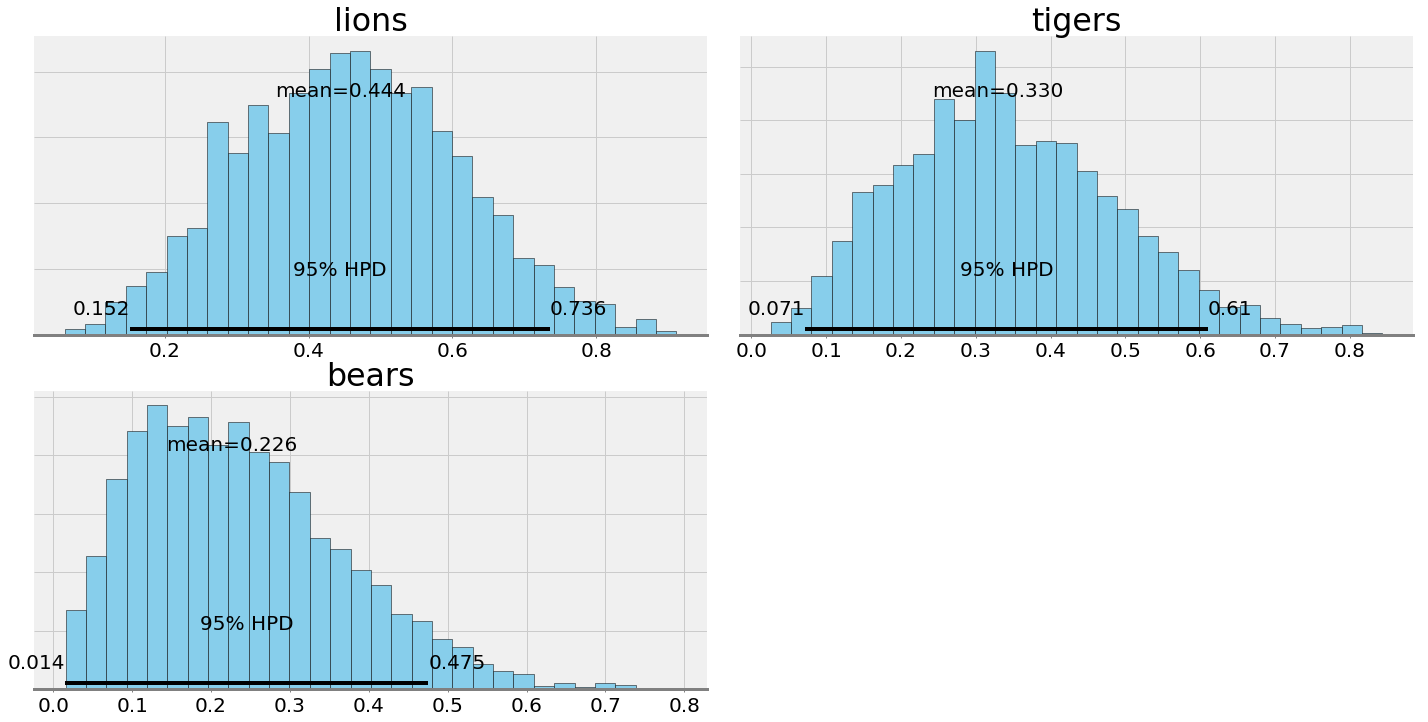

In [15]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

The 95% HPD is the same idea as a 95% confidence interval in frequentist statistics. In Bayesian stats, this is called the Highest Posterior Density.

## Traceplot

The traceplot shows a kernel density estimate and all the samples that were drawn on the right. We collapse the chains on th plots (`combined = True`) but in reality we drew 2 independent chains.

C:\Users\willk\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


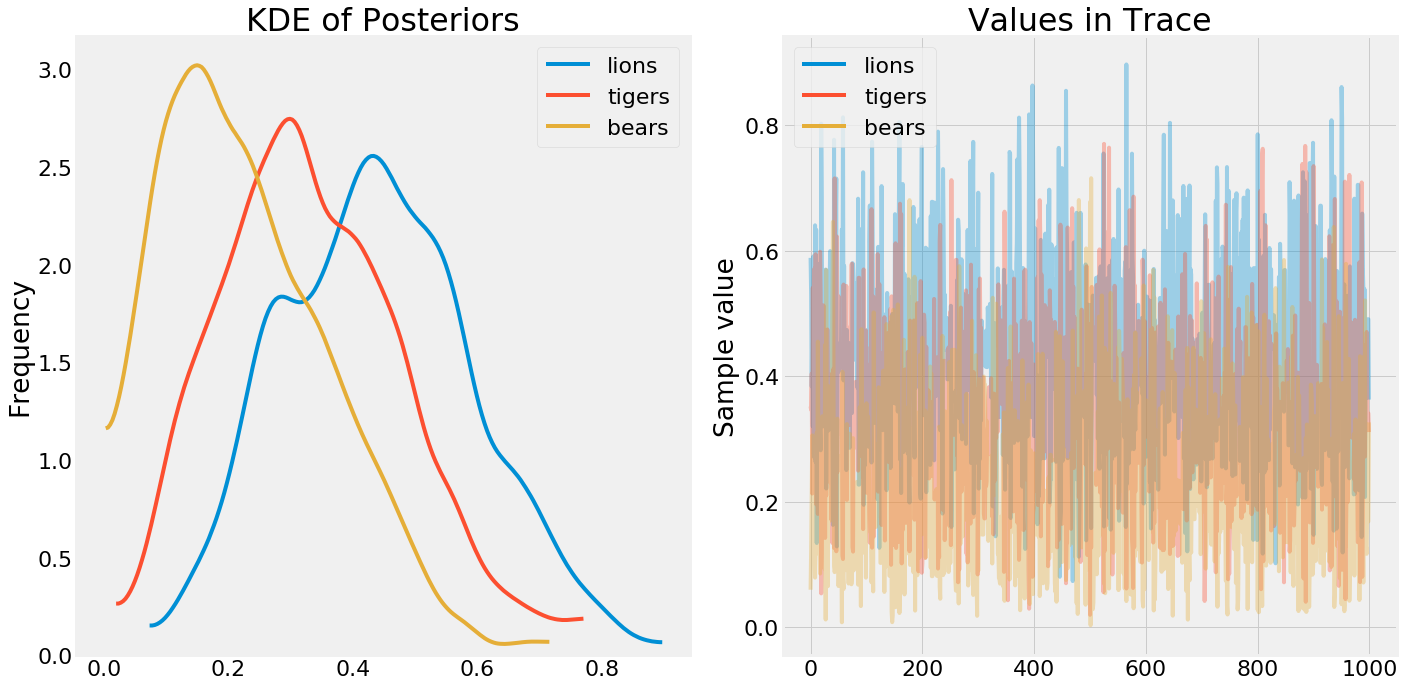

In [16]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 10), combined = True, skip_first = 1000);
ax[0][0].set_title('KDE of Posteriors'); ax[0][1].set_title('Values in Trace');
add_legend(ax[0][0])
add_legend(ax[0][1])

# Maximum A Posteriori Result with PyMC3

In [17]:
with model:
    # Find the maximum a posteriori estimate
    map_ = pm.find_MAP()
    
display_probs(dict(zip(animals, map_['parameters'])))

logp = -1.8042, ||grad|| = 1.118: 100%|██████████| 7/7 [00:00<00:00, 878.23it/s]


Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


The MAP estimates are exactly the same as the observations. These are also the results that a frequentist would come up with! 

# Sample From Posterior

We can now use the posterior (contained in the `trace`) to draw samples of data. For example, we can simulate 1000 trips to the wildlife preserve as follows.

In [18]:
with model:
    samples = pm.sample_ppc(trace, samples = 1000)
    
dict(zip(animals, samples['observed_data'].mean(axis = 0)))

100%|██████████| 1000/1000 [00:02<00:00, 476.68it/s]


{'lions': 2.605, 'tigers': 2.021, 'bears': 1.374}

These represent the estimate number of each species we'd see over 1000 trips to the preserve.

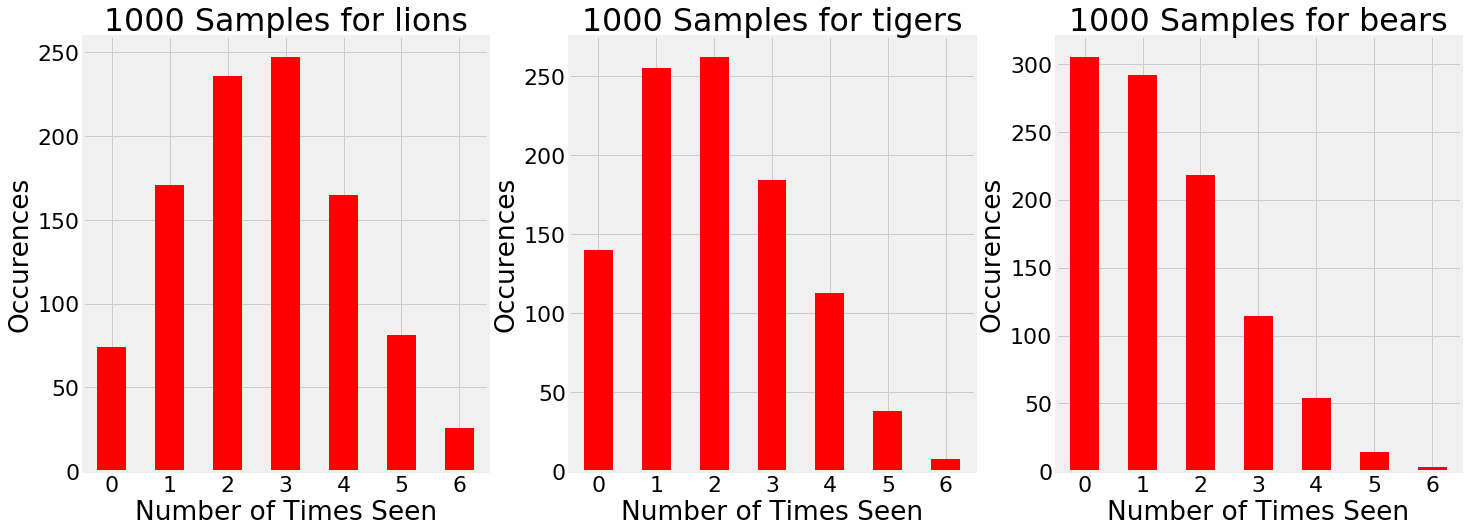

In [19]:
sample_df = pd.DataFrame(samples['observed_data'], columns = animals)

plt.figure(figsize = (22, 8))
for i, animal in enumerate(sample_df):
    plt.subplot(1, 3, i+1)
    sample_df[animal].value_counts().sort_index().plot.bar(color = 'r');
    plt.xticks(range(7), range(7), rotation = 0);
    plt.xlabel('Number of Times Seen'); plt.ylabel('Occurences');
    plt.title(f'1000 Samples for {animal}');

Interestingly, the most likely number of bears is zero! 

# Dirichlet Distribution

We can plot the Dirichlet Distribution as a triangle with colors indicating the value of the hyperpriors. This code is taken from the following sources.

http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

https://gist.github.com/tboggs/8778945

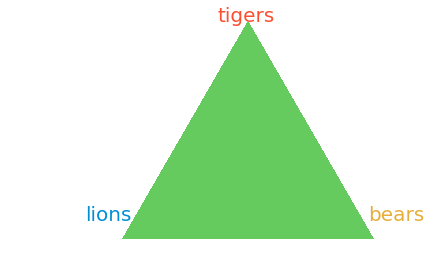

In [20]:
draw_pdf_contours(Dirichlet(alphas))
annotate_plot()

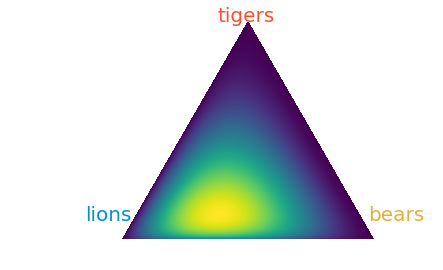

In [21]:
draw_pdf_contours(Dirichlet(6 * pvals))
annotate_plot();

# Next Observation

In order to find what we can expect from the next observation, we draw a single sample 10000 from a multinomial distribution. The probability of seeing each species is proportional to that obtained from the sampling.

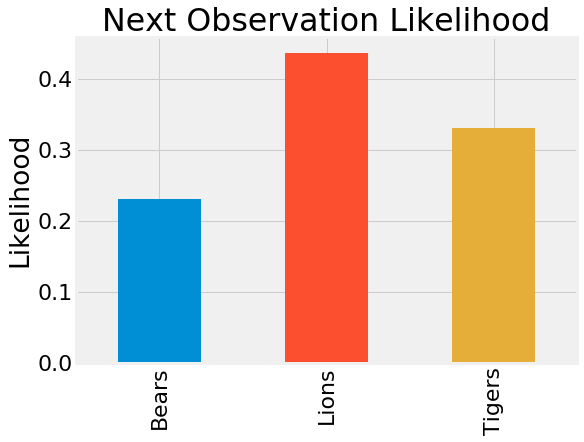

In [22]:
next_obs = np.random.multinomial(n = 1, pvals = pvals, size = 10000)

# Data manipulation
next_obs = pd.melt(pd.DataFrame(next_obs, columns = ['Lions', 'Tigers', 'Bears'])).\
            groupby('variable')['value'].\
            value_counts(normalize=True).to_frame().\
             rename(columns = {'value': 'total'}).reset_index()
next_obs = next_obs.loc[next_obs['value'] == 1]

# Bar plot
next_obs.set_index('variable')['total'].plot.bar(figsize = (8, 6));
plt.title('Next Observation Likelihood');
plt.ylabel('Likelihood'); plt.xlabel('');

In [23]:
next_obs

,variable,value,total
1,Bears,1,0.2308
3,Lions,1,0.4375
5,Tigers,1,0.3317


# Tuning vs Broken In Samples

To see if the tuning samples display any major difference from those past the burn-in period, we can plot both distributions. Traditionally, the tuning samples are discarded.

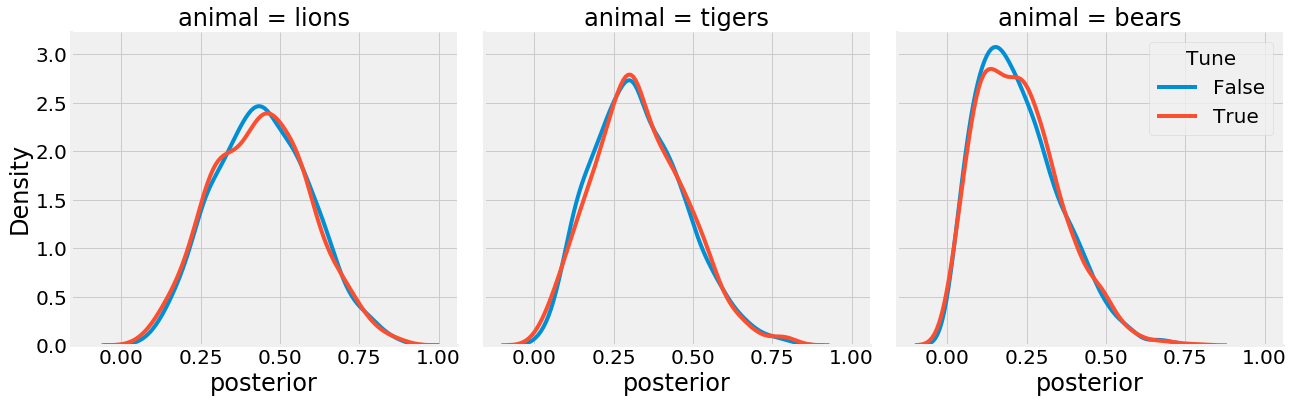

In [24]:
all_df = pd.melt(all_df, id_vars=['tune'], 
                   var_name='animal', value_name='posterior')

plt.rcParams['font.size'] = 20
g = sns.FacetGrid(data = all_df, hue = 'tune', col = 'animal', size = 6)
g.map(sns.kdeplot, 'posterior');
l = plt.legend(prop={'size': 20});
l.set_title('Tune');
g.set_ylabels(label = 'Density');

# Conclusions

In [25]:
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.444018,0.152194,0.002562,0.152288,0.735601,2779.622971,1.000291
tigers,0.330000,0.144525,0.002627,0.071472,0.610482,2727.795655,1.000087
bears,0.225982,0.130168,0.002613,0.014302,0.475272,2475.737395,0.999708



Given the question posed, we can provide the following answers:

__Estimated Prevalence__

Below are the means and 95% HPD for the estimates

* Lions: 44.5% (16.9% - 75.8%)
* Tigers: 32.7% (6.7% - 60.5%)
* Bears: 22.7% (1.7% - 50.0%)

__Probability Next Observation is a Bear__

Based on the sampling, 22.9%. 

(Results may change from one run to the next. This is due to the stochastic nature of MCMC). 

The best parts about Bayesian Inference are the incorporation of priors and the uncertainty inherent in the methods. With the scant evidence, we can provide estimates, but only with a large amount of uncertainty. More visits to the wildlife preserve would certainly help to clear up the matter! 

## Next Steps

If we have more observations, we can simply add them to the model as follows:

In [26]:
c = np.array([[3, 2, 1],
              [2, 3, 1],
              [3, 2, 1],
              [2, 3, 1]])

with pm.Model() as model:
    # Dirichlet hyperparameters are uniform hyperpriors
    hyperpriors = pm.Uniform('hyperpriors', shape = 3, observed = alphas)
    # Probabilities for each species
    parameters = pm.Dirichlet('parameters', a=hyperpriors, shape=3)
    # Observed data is a multinomial distribution with 6 trials
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 405.81draws/s]


In [27]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.403880,0.092552,0.001896,0.238665,0.597055,2172.218518,0.999828
tigers,0.411601,0.090915,0.001975,0.243581,0.588124,2086.615145,0.999878
bears,0.184519,0.074620,0.001614,0.047123,0.325108,2052.651319,0.999501


The uncertainty of the prevalence of bears has descreased and the prevalence of the lions and tigers is nearly identical as expected. As we gather more data, we can incorporate it into the model to get more accurate estimates. 

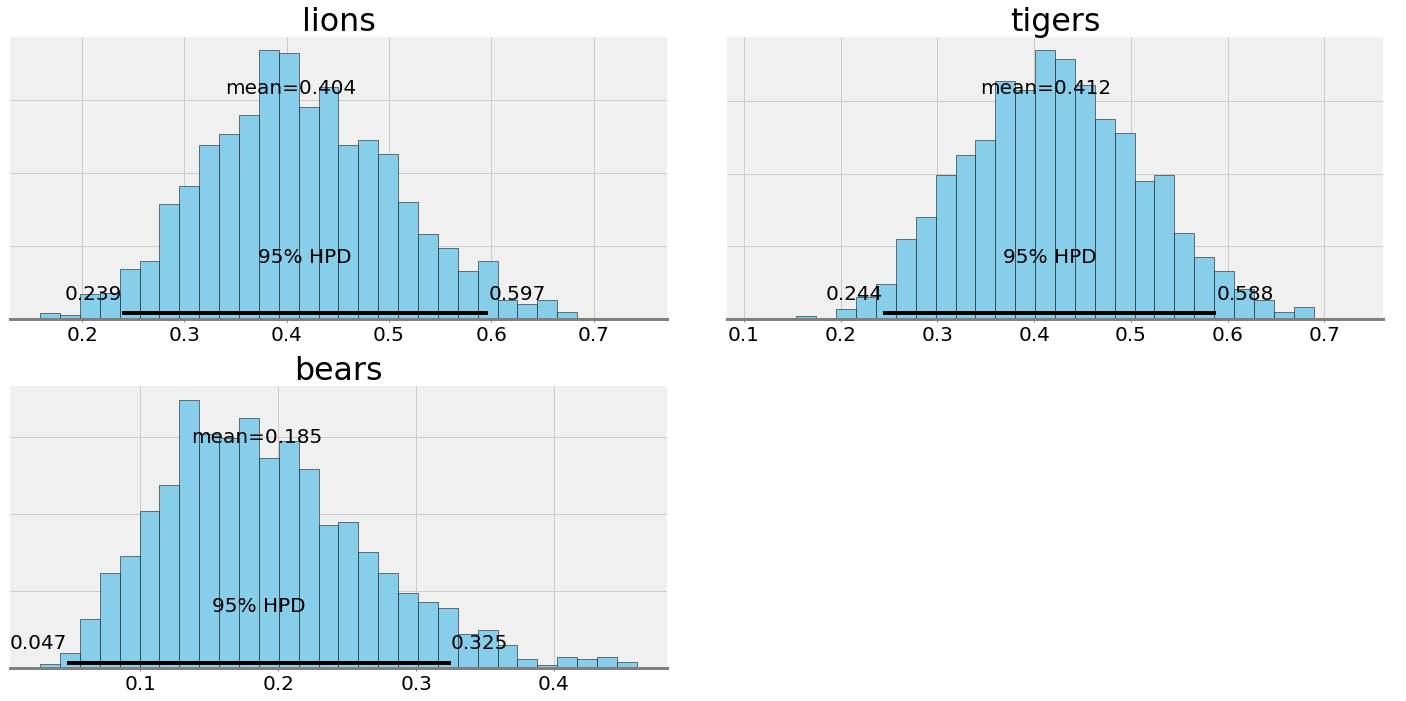

In [28]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

## Altering Priors

Below we change the alpha values which places more (higher values) or less (lower values) emphasis on the priors. With a greater emphasis, the posteriors are closer to each other, but with smaller emphasis, the posteriors are more reflective of the observations. 

In [29]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])
alphas = np.array([10, 10, 10])

def sample_with_priors(alphas):
    with pm.Model() as model:
        # Dirichlet hyperparameters are uniform hyperpriors
        # hyperpriors = pm.Uniform('hyperpriors', shape = 3, observed = alphas)
        # Probabilities for each species
        parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
        # Observed data is a multinomial distribution with 6 trials
        observed_data = pm.Multinomial(
            'observed_data', n=6, p=parameters, shape=3, observed=c)    

        trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    return trace

In [30]:
t = sample_with_priors(np.array([10, 10, 10]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 867.36draws/s] 


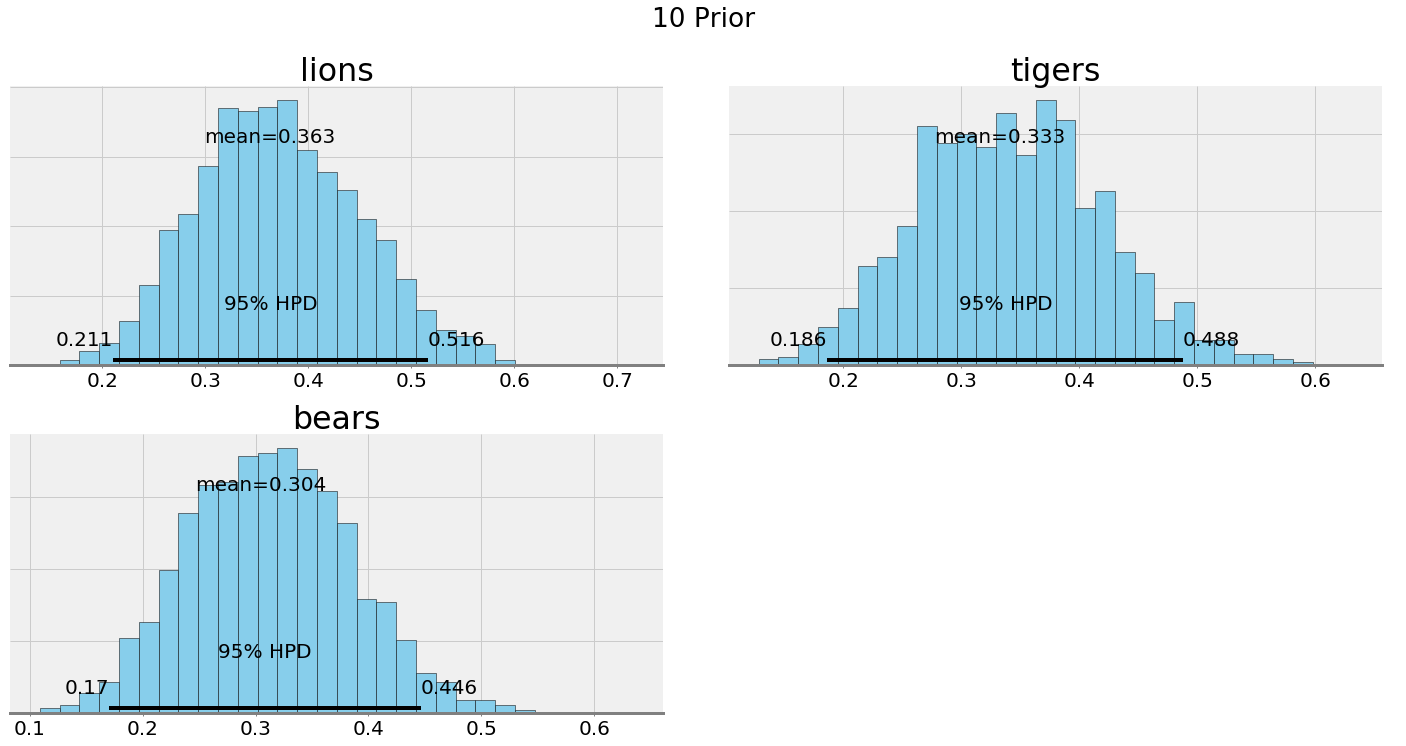

In [32]:
ax = pm.plot_posterior(t, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'10 Prior', y = 1.05);

In [30]:
trace_dict = {}
for alpha_array in [np.array([1, 1, 1]), np.array([0.1, 0.1, 0.1]), np.array([0.5, 0.5, 0.5])]:
    trace_dict[str(alpha_array[0])] = sample_with_priors(alpha_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 608.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 592.94draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 613.20draws/s] 


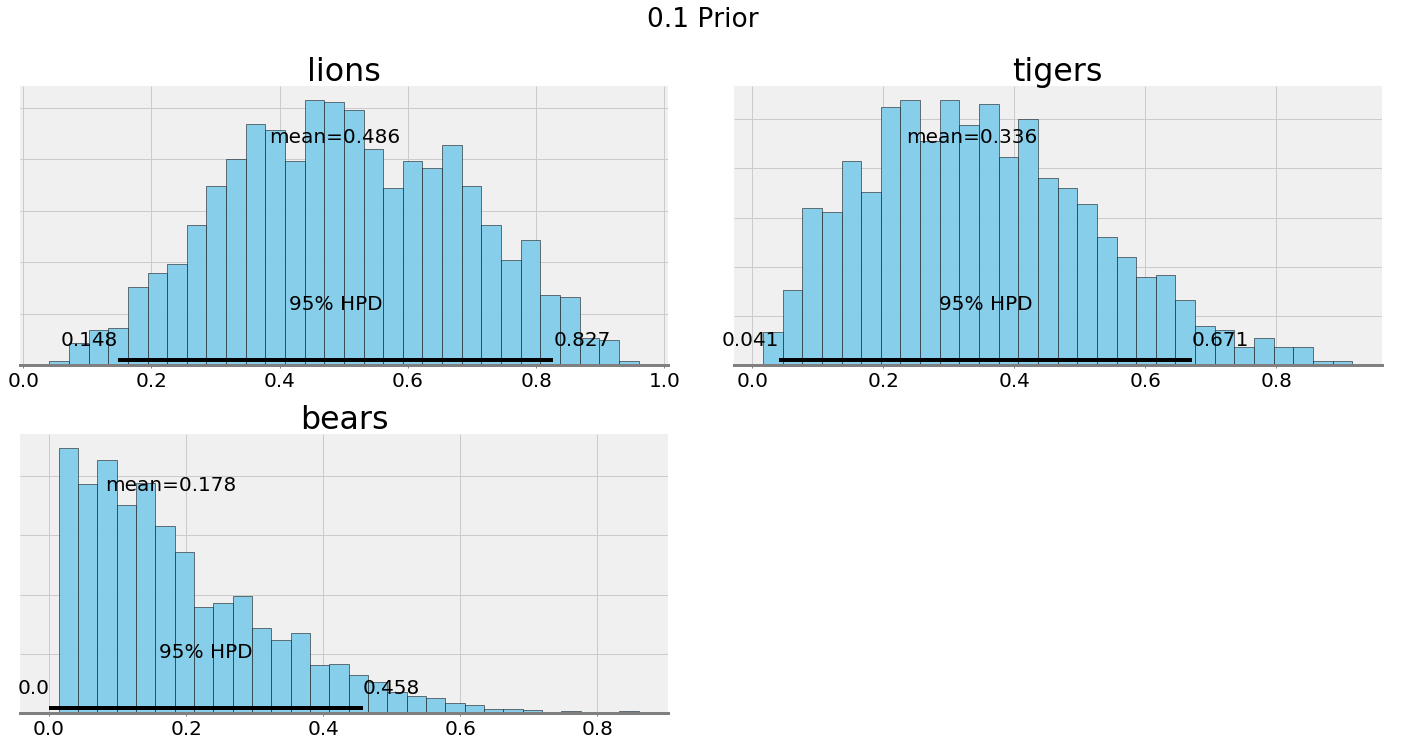

In [31]:
prior = '0.1'
trace = trace_dict[prior]

ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'{prior} Prior', y = 1.05);

In [32]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.486178,0.182540,0.004160,0.148061,0.827008,2239.025055,0.999525
tigers,0.335813,0.173570,0.003993,0.041314,0.670795,1768.902027,1.000122
bears,0.178009,0.142854,0.003889,0.000356,0.457994,1697.039542,1.000073


With a smaller weight on the priors, the data has a greater influence on the posterior. Therefore, the mean values are nearly equal to the prevalence in the observations.

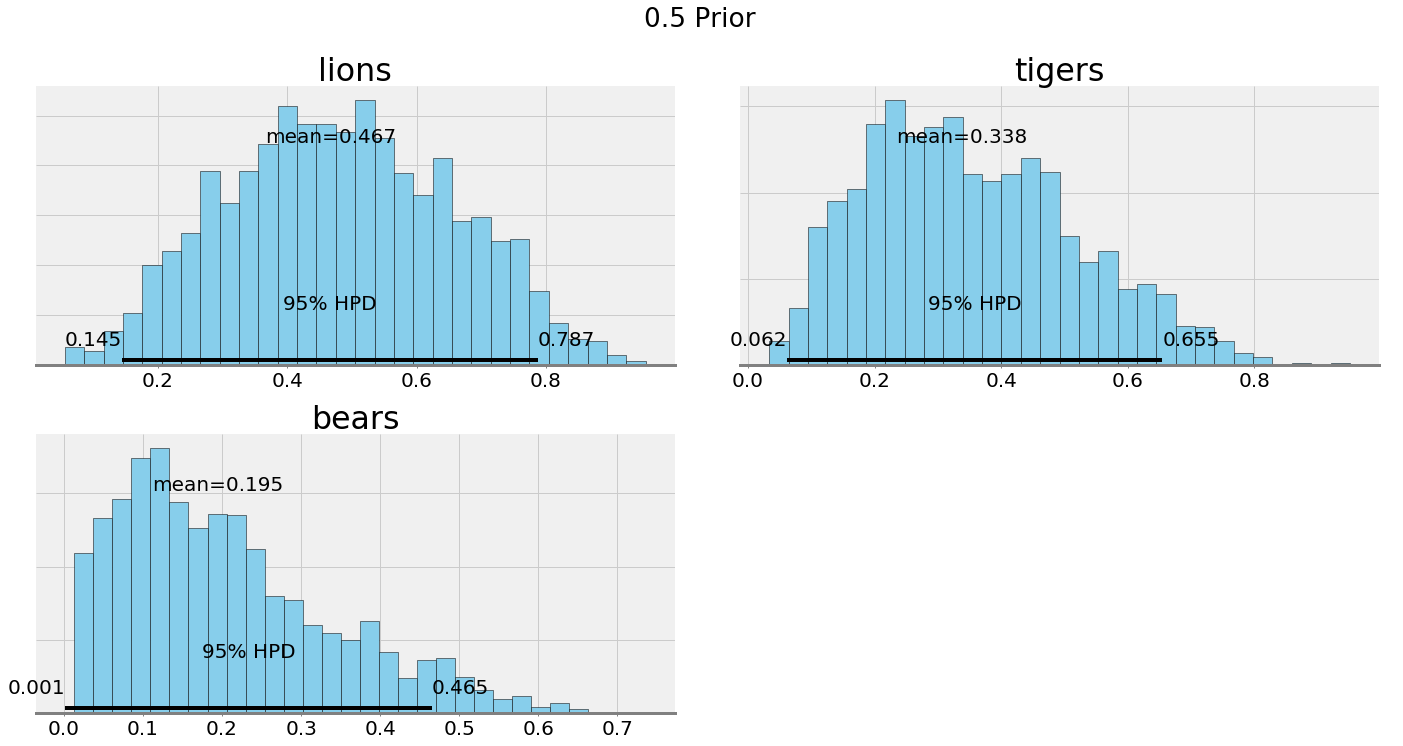

In [33]:
prior = '0.5'
trace = trace_dict[prior]

ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'{prior} Prior', y = 1.05);

In [34]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.466764,0.174351,0.003773,0.144898,0.787162,2071.791490,0.999827
tigers,0.338432,0.164624,0.003766,0.061670,0.654715,1647.955237,1.000361
bears,0.194803,0.137118,0.003153,0.001019,0.465299,1844.063644,0.999649


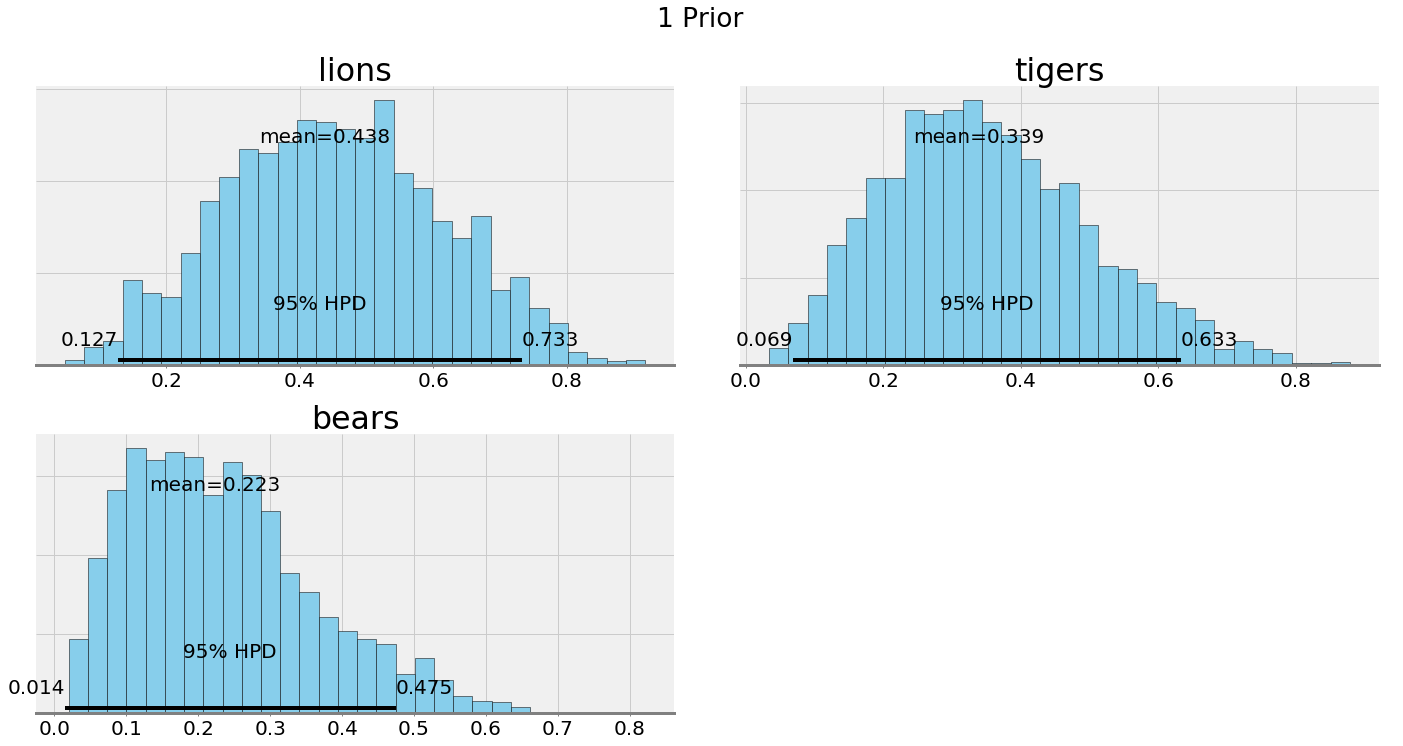

In [35]:
prior = '1'
trace = trace_dict[prior]

ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);
    
plt.suptitle(f'{prior} Prior', y = 1.05);

In [36]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.438157,0.160531,0.003407,0.127372,0.732571,2152.303466,0.999559
tigers,0.338736,0.149940,0.003392,0.069151,0.633109,1995.996050,0.999508
bears,0.223107,0.129539,0.002607,0.014103,0.474587,1904.705707,0.999663


With the greatest emphasis on the priors, they play a larger role in the posterior estimates and therefore tend to bring the estimated posterior means closer together. The data has a smaller impact when the priors are greater.

Overall, the choice of the hyperpriors depends on our confidence in the prior distribution. If we have good reason to believe all the animals are represented at the same frequency, then we should increase the weight of the priors.